In [1]:
import geopandas as gpd
import pandas as pd
import os
import json
import pylab as pl

#FBB: StringIO is not available in Python 3
# for python 3 compatibility change this import to:
#import StringIO
try:
    import StringIO
except ImportError:
    import io 

import requests
import zipfile

#FBB: urllib is not available in Python 3
# for python 3 compatibility change this import to:
#import urllib2
try:
    import urllib2 as urllib2
except ImportError:
    import urllib.request as urllib2
    
import numpy as np
import statsmodels.api as sm
from pandas.tools.plotting import scatter_matrix
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
DFDATA = os.getenv('DFDATA')
PUI2016 = os.getenv('PUI2016')
PUIDATA = os.getenv('PUIDATA')

In [3]:
s = json.load(open(PUI2016 + '/fbb_matplotlibrc.json'))
pl.rcParams.update(s)

//anaconda/lib/python3.5/site-packages/matplotlib-2.0.0b4+2344.g7b27a1b-py3.5-macosx-10.6-x86_64.egg/matplotlib/__init__.py:910: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/lib/python3.5/site-packages/matplotlib-2.0.0b4+2344.g7b27a1b-py3.5-macosx-10.6-x86_64.egg/matplotlib/__init__.py:910: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Compare the energy consumed by a building to the number of units in the building

In [4]:
#data on energy consumption
url = "https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD"
"curl -o " + PUI2016 + "/energy.csv " + url
#url = str("https://data.cityofnewyork.us/resource/rgfe-8y2z.csv")
energy = pd.DataFrame.from_csv(url) 
energy.head()
#energy.columns

,"NYC Borough, Block, and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,Site EUI(kBtu/ft2),...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
Record Number,,,,,,,,,,,,,,,,,,,,,
12086,1000410001,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,NaN,...,NaN,NaN,Not Available,NaN,NaN,NaN,918919,NaN,Office,NaN
14354,4021460028,NaN,NaN,NaN,63-10,108 STREET,Queens,11375,No Submission Matched to BBL,NaN,...,Yes,None,NaN,NaN,NaN,NaN,NaN,82730,NaN,1
12150,2027620097,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,NaN,...,NaN,NaN,Not Available,NaN,NaN,NaN,64200,NaN,Multifamily Housing,NaN
12590,1006700001,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001,No Submission Matched to BBL,NaN,...,No,None,NaN,NaN,NaN,NaN,NaN,440360,NaN,1
15591,2048300034,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,NaN,...,NaN,None,Not Available,NaN,NaN,NaN,50000,NaN,Multifamily Housing,NaN


In [5]:
r = requests.get("http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip") 

#python3 compatibility change
try:
    z = zipfile.ZipFile(StringIO.StringIO(r.content))
except NameError: 
    z = zipfile.ZipFile(io.BytesIO(r.content))
p = z.extractall(PUIDATA)
units = gpd.read_file(PUIDATA + "/" + "MNMapPLUTO.shp")

In [6]:
units.columns

Index(['APPBBL', 'APPDate', 'Address', 'AllZoning1', 'AllZoning2',
       'AreaSource', 'AssessLand', 'AssessTot', 'BBL', 'BldgArea', 'BldgClass',
       'BldgDepth', 'BldgFront', 'Block', 'BoroCode', 'Borough', 'BsmtCode',
       'BuiltCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR',
       'CondoNo', 'Council', 'EDesigNum', 'Easements', 'ExemptLand',
       'ExemptTot', 'Ext', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea',
       'HealthArea', 'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot',
       'LotArea', 'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PLUTOMapID', 'PolicePrct',
       'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea', 'SHAPE_Area',
       'SHAPE_Leng', 'SPDist1', 'SPDist2', 'Sanborn', 'SanitBoro', 'SanitDist',
       'SanitSub', 'SchoolDist', 'SplitZone', 'StrgeArea', 'TaxMap',
       'Tract2010', 'UnitsRe

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ade6588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11af4fcf8>]], dtype=object)

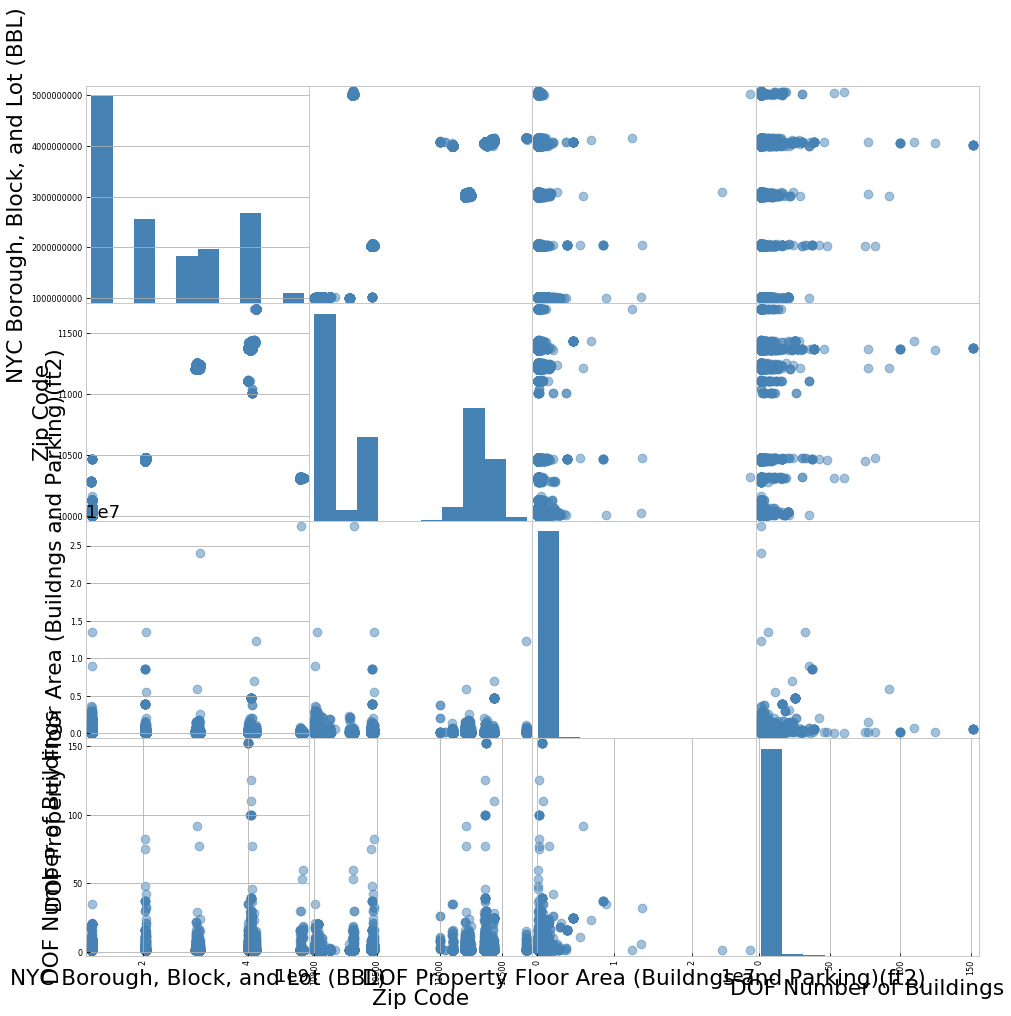

In [7]:
#scatter matrix shows that many columns don't have float values, or values that can convert to 
#float
scatter_matrix (energy, s=300, figsize=(16, 16))



### clean the energy dataset so that all values in the energy consumption column can be converted to float

In [8]:
#FBB while this is fine, remember that the larger dataframe "units" is still in memory, 
#while if yuu dropped the columns you do not need you would have removed them from meory

#columns needed
#'NYC Borough, Block, and Lot (BBL)'
#'Site EUI(kBtu/ft2)'
#'Reported Property Floor Area (Building(s)) (ft²)'
energy2 = energy.drop(['Co-reported BBL Status', 'BBLs Co-reported', 'Reported NYC Building Identificaiton Numbers (BINs)',
       'Street Number', 'Street Name', 'Borough', 'Zip Code',
       'DOF Benchmarking Submission Status', 'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)', 'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings'], 1)

In [11]:
energy2.head()


,"NYC Borough, Block, and Lot (BBL)",Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
Record Number,,,
12086,1000410001,NaN,918919
14354,4021460028,NaN,NaN
12150,2027620097,NaN,64200
12590,1006700001,NaN,NaN
15591,2048300034,NaN,50000


In [12]:
def canconvert(mydata):
    try:
        float(mydata)
        return True
    except ValueError:
        return False

indx = (np.vectorize(canconvert)(energy2['Site EUI(kBtu/ft2)']))
print("True entries %d"%sum(indx))
energy2['Site EUI(kBtu/ft2)'][~indx] = float('NaN')

indx2 = (np.vectorize(canconvert)(energy2['Reported Property Floor Area (Building(s)) (ft²)']))
print("True entries %d"%sum(indx))
energy2['Reported Property Floor Area (Building(s)) (ft²)'][~indx2] = float('NaN')

indx3 = (np.vectorize(canconvert)(energy2['NYC Borough, Block, and Lot (BBL)']))
print("True entries %d"%sum(indx))
energy2['NYC Borough, Block, and Lot (BBL)'][~indx3] = float('NaN')

True entries 15513
True entries 15513

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



True entries 15513


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
#energy2['Site EUI(kBtu/ft2)'] = energy['Site EUI(kBtu/ft2)'].convert_objects(convert_numeric=True)
#energy2['Reported Property Floor Area (Building(s)) (ft²)'] = energy['Reported Property Floor Area (Building(s)) (ft²)'].convert_objects(convert_numeric=True)
#print(np.dtype(energy2['Site EUI(kBtu/ft2)']))

In [13]:
#FBB: do not print these many lines. if the print is too large nobody can actually look at it
# if you want to check the error you can just call the function
#print(energy2['Site EUI(kBtu/ft2)'].astype(float))

#exceptions be specified (PEP8) which means which exception? only ValueError
try: 
    energy2['Site EUI(kBtu/ft2)'] = energy2['Site EUI(kBtu/ft2)'].astype(float)
except ValueError:
    print("Conversion failed")
    


In [14]:
try: 
    units.BBL = units.BBL.astype(float)
except ValueError:
    print("Conversion failed")    

### merge the datasets on a common column name

In [38]:
#FBB while this works fine, remember that the larger dataframe "units" is still in memory, 
#while if yuo dropped the columns you do not need you would have removed them from meory
units_reduced = pd.DataFrame()

#FBB: remoduce the range: specifically remove Units=0
indx = (units['UnitsTotal']>1) & (units['UnitsTotal']<2e3)
units_reduced['BBL'] = units['BBL'][indx]
units_reduced['UnitsTotal'] = units['UnitsTotal'][indx]

In [39]:
energy2 = energy2.rename(columns = {'NYC Borough, Block, and Lot (BBL)':'BBL'})
energy2.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),EnergyTotal
Record Number,,,,
3028,1013110040,125.4,330000,4.138200e+07
12140,2022150042,6224.5,342048,2.129078e+09
15011,1010140033,154.9,841709,1.303807e+08
9863,4002520018,46.0,390400,1.795840e+07
12237,4004370002,66.2,528060,3.495757e+07


In [40]:
#FBB while this is fine, remember that the larger dataframe "units" is still in memory, 
#while if yuu dropped the columns you do not need you would have removed them from meory

#energy2['NYC Borough, Block, and Lot (BBL)'] = energy2['NYC Borough, Block, and Lot (BBL)'].astype(float)
energy2['Site EUI(kBtu/ft2)'] = energy2['Site EUI(kBtu/ft2)'].astype(float)
#FBB dont extend lines past the cell use \ to go to a new line, or just ne line if the statement is in ()
energy2['Reported Property Floor Area (Building(s)) (ft²)'] = \
    energy2['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)

In [41]:
print(np.dtype(energy2['Site EUI(kBtu/ft2)']))
print(np.dtype(energy2['Reported Property Floor Area (Building(s)) (ft²)']))

energy2['EnergyTotal'] = energy2['Site EUI(kBtu/ft2)'] * energy2['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)

#FBB 
energy2 = energy2[energy2['EnergyTotal']>0]

float64
float64


In [42]:
#FBB while this is fine, remember that the larger dataframe "units" is still in memory, 
#while if yuu dropped the columns you do not need you would have removed them from meory

merged = pd.merge(energy2, units_reduced, on='BBL', how="inner")
merged.head()
print(len(merged))
#FBB while this is fine, remember that the larger dataframe "units" is still in memory, 
#while if yuu dropped the columns you do not need you would have removed them from meory
#RIGHT NOW YOU HAVE units, energy, energy2, units_reduced, merged and merged_dropped all in memory!

merged_dropped = merged.dropna()
print(len(merged_dropped))

4654
4654


In [43]:
#scatter_matrix (merged_dropped, s=30, figsize=(16, 16))

In [44]:
np.dtype(merged_dropped['UnitsTotal']), np.dtype(merged_dropped['EnergyTotal']),

(dtype('int64'), dtype('float64'))

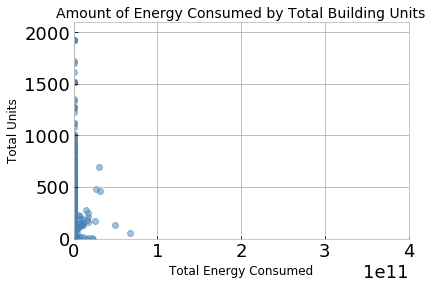

In [45]:
pl.scatter(x=merged_dropped['EnergyTotal'], y=merged_dropped['UnitsTotal'],alpha=0.5)
pl.axis([-5, 4e11, -5, 2100])
pl.title('Amount of Energy Consumed by Total Building Units', fontsize=14)
pl.xlabel('Total Energy Consumed', fontsize=12)
pl.ylabel('Total Units', fontsize=12)
pl.show()

### Caption for plot
This plot depicts the total amount of units as a function of total energy consumed.

Text(0.5,1,'Total Energy Consumption by Total Unit')

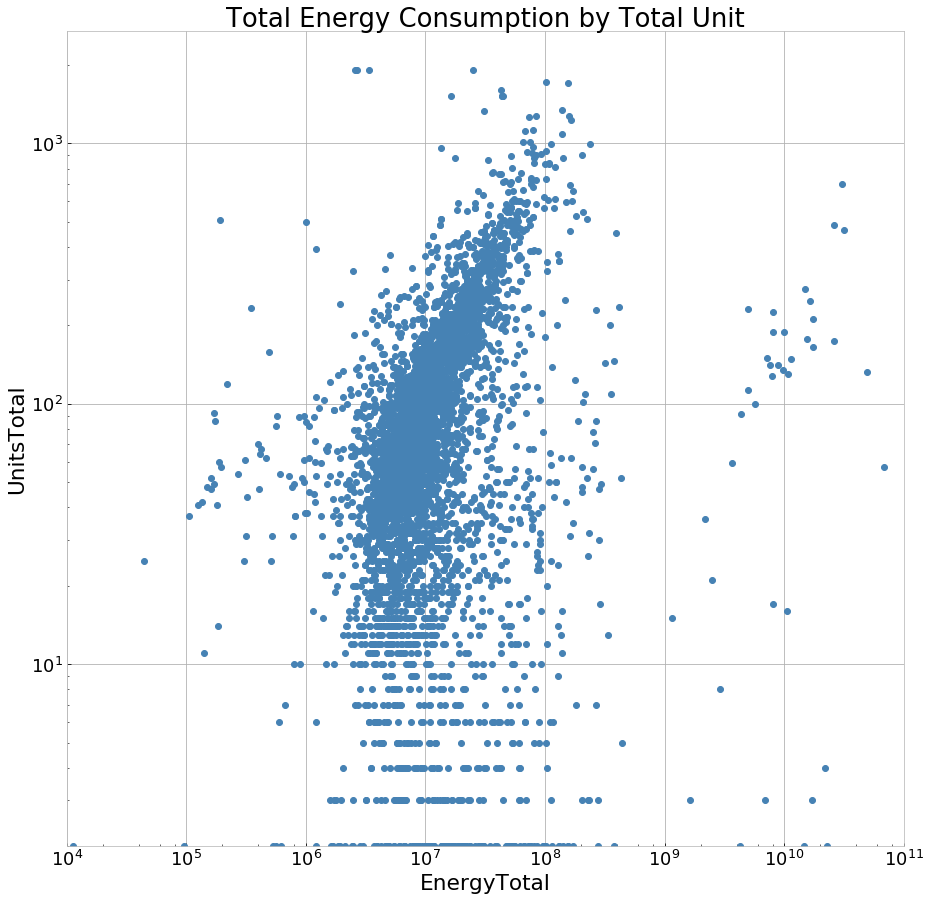

In [46]:
plt.figure(figsize=(15,15))
plt.loglog(merged_dropped['EnergyTotal'], merged_dropped['UnitsTotal'], 'o')
plt.xlim([10**4, 10**11])
plt.xlabel("EnergyTotal")
plt.ylabel("UnitsTotal")
plt.title("Total Energy Consumption by Total Unit")

Text(0.5,1,'Total Energy Consumption by Total Unit')

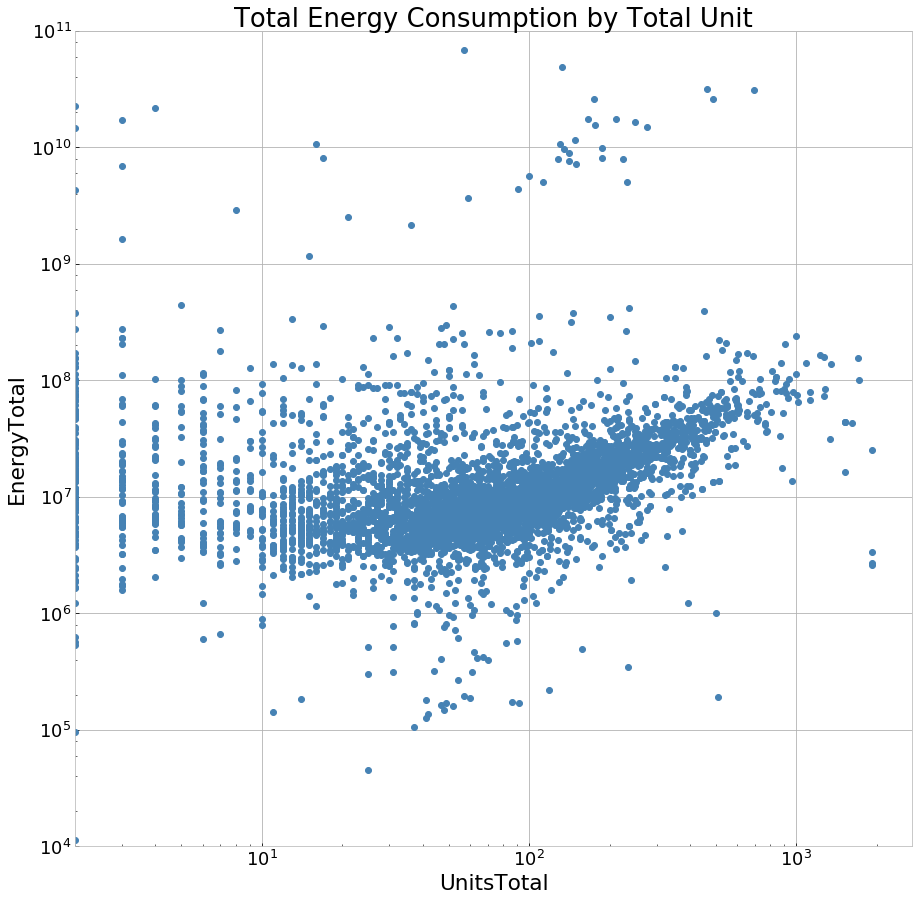

In [47]:
plt.figure(figsize=(15,15))
plt.loglog(merged['UnitsTotal'], merged['EnergyTotal'], 'o')
plt.ylim([10**4, 10**11])
plt.ylabel("EnergyTotal")
plt.xlabel("UnitsTotal")
plt.title("Total Energy Consumption by Total Unit")

### create a line of best fit in log space

In [48]:
#fit a line units vs energy

#X = sm.add_constant(np.log10(merged['UnitsTotal']))
#y = np.log10(merged['EnergyTotal'])
#linmodel = sm.OLS(np.log10(merged['EnergyTotal']), X, missing='drop').fit() # ignores entires where x or y is NaN

In [49]:
y = np.log10(merged_dropped['EnergyTotal'])
X = sm.add_constant(np.log10(merged_dropped['UnitsTotal']))
print (X)

      const  UnitsTotal
0         1    1.748188
1         1    0.301030
2         1    0.903090
3         1    1.380211
4         1    1.380211
5         1    1.792392
6         1    1.929419
7         1    2.107210
8         1    1.000000
9         1    1.785330
10        1    2.686636
11        1    2.656098
12        1    1.000000
13        1    1.832509
14        1    1.949390
15        1    0.954243
16        1    1.579784
17        1    0.698970
18        1    1.857332
19        1    1.748188
20        1    1.792392
21        1    1.977724
22        1    1.785330
23        1    1.785330
24        1    2.720986
25        1    1.724276
26        1    1.633468
27        1    1.819544
28        1    2.378398
29        1    2.247973
...     ...         ...
4624      1    1.792392
4625      1    1.792392
4626      1    0.477121
4627      1    0.301030
4628      1    0.301030
4629      1    0.602060
4630      1    0.301030
4631      1    1.591065
4632      1    1.662758
4633      1    2

[ 7.0361629   6.7300819   6.85742053 ...,  7.00293053  6.90882427
  6.7300819 ]


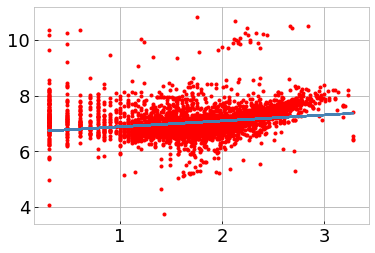

In [50]:
linmodel = sm.OLS(y, X).fit()
print(linmodel.predict(X))
pl.plot(np.log10(merged_dropped['UnitsTotal']), np.log10(merged_dropped['EnergyTotal']), 'r.')
pl.plot(np.log10(merged_dropped['UnitsTotal']), linmodel.predict(X), '-')

#FBB now it works, but the range may still be further adjusted

In [ ]:
#fit a line energy vs units

#X_second = sm.add_constant(np.log10(merged['EnergyTotal']))
#y_second = np.log10(merged['UnitsTotal'])
#linmodel_second = sm.OLS(y_second, X_second, missing='drop').fit()

### fit a second degree curve to the datasets: ax^2+bx+c

In [ ]:
#from federica's notebook:

#np.polyfit(x, y, 2)

#statsmodels.formula.api
#formula = 'y ~ 1 + x + I(x ^ 2.0)'

#which fit summary is better? the linear or the exponentiated?
#could you do a likelihood ratio?

## extra credit

In [ ]:
#use wls weighted square fit instead of ordinary least squares
#give weights to the points
#estimate the errors

#create a function by hand that minimizes the residuals